In [1]:
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformation
import data_filter as dafi
import estimate_height as esth

from scipy import signal

WAVELENTH_S1 = 0.1905 # meter


In [2]:
import math
x = 4155252.3307
y = 674064.7850
z = 4775969.2638
lat,lon,height = transformation.xyz2latlon(x,y,z)
print(lat/math.pi*180)
print(lon/math.pi*180)
print(height)

48.797647635874426
9.214252131825374
270.97025138139725


In [3]:
main_path = 'E:/OneDrive/Studium/MA/data/20220526/2/'
main_path = os.path.abspath('../data/20220526/2/')

#main_path = 'E:/OneDrive/Studium/MA/data/20220526/3/'

data_dict = dafi.generate_dataframe(main_path)
satellite_list = data_dict.keys()

azimut_mask = [140,320]
elevation_mask = [0,60]
for satellite_code in satellite_list:
    data_dict[satellite_code] = dafi.azimut_filter(data_dict[satellite_code],azimut_mask)
    data_dict[satellite_code] = dafi.elevation_filter(data_dict[satellite_code],elevation_mask)

In [4]:
print(satellite_list)

dict_keys(['G01', 'G03', 'G04', 'G06', 'G09', 'G17', 'G19', 'G31', 'G11', 'G02', 'R04', 'R05', 'R06', 'R14', 'R15', 'R20', 'R21', 'R22', 'R07', 'E04', 'E05', 'E09', 'E11', 'E36', 'E34', 'E01', 'G07', 'E31', 'G20', 'G16', 'G30', 'R23', 'R09'])


In [5]:
satellite_code = 'G01'
dataframe = data_dict[satellite_code]
print(dataframe)

                          time   azimut  elevation   snr1   snr2
0    2022-05-26 19:31:05+00:00  150.067     24.358  43.80  43.40
1    2022-05-26 19:31:06+00:00  150.070     24.350  43.75  43.60
2    2022-05-26 19:31:07+00:00  150.072     24.343  44.10  44.10
3    2022-05-26 19:31:08+00:00  150.075     24.336  43.95  43.85
4    2022-05-26 19:31:09+00:00  150.077     24.328  43.95  43.80
...                        ...      ...        ...    ...    ...
3495 2022-05-26 20:29:20+00:00  155.900      0.030    NaN    NaN
3496 2022-05-26 20:29:21+00:00  155.901      0.024    NaN    NaN
3497 2022-05-26 20:29:22+00:00  155.902      0.017    NaN    NaN
3498 2022-05-26 20:29:23+00:00  155.903      0.010    NaN    NaN
3499 2022-05-26 20:29:24+00:00  155.904      0.004    NaN    NaN

[3500 rows x 5 columns]


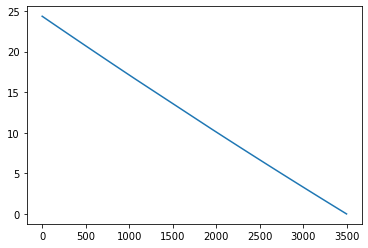

In [6]:
dataframe_sort = dataframe.sort_values(by='elevation')
plt.plot(dataframe_sort['elevation'])

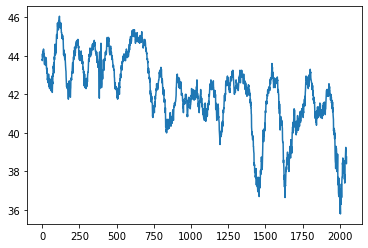

In [7]:
plt.plot(dataframe_sort['snr1'])

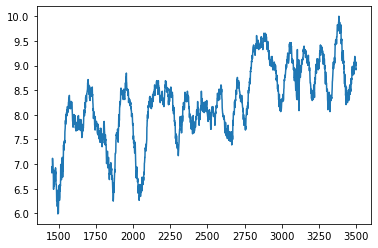

In [8]:
snr1_volt = np.array(np.exp(dataframe_sort['snr1']/20))
plt.plot(snr1_volt)

In [9]:
elevation_sort = np.array(dataframe_sort['elevation'])
non_nan_index = ~np.isnan(snr1_volt)

elevation_filtered = elevation_sort[non_nan_index]
elevation_filtered = elevation_filtered.reshape(elevation_filtered.size,1)
snr1_volt_filtered = snr1_volt[non_nan_index]
snr1_volt_filtered = snr1_volt_filtered.reshape(snr1_volt_filtered.size,1)

design_matrix = np.concatenate((elevation_filtered**2,elevation_filtered,np.ones((elevation_filtered.size,1))),axis=1)
print(design_matrix)


[[ 95.883264   9.792      1.      ]
 [ 96.020401   9.799      1.      ]
 [ 96.157636   9.806      1.      ]
 ...
 [592.581649  24.343      1.      ]
 [592.9225    24.35       1.      ]
 [593.312164  24.358      1.      ]]


In [10]:
para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),design_matrix.T),snr1_volt_filtered)
print(para)

[[-2.57570412e-04]
 [ 1.33915181e-01]
 [ 6.04822858e+00]]


(2046, 1)


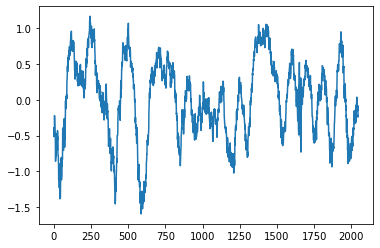

In [12]:
print(snr1_volt_filtered.shape)
snr1_ref = snr1_volt_filtered - (elevation_filtered**2 * para[0,0] + para[1,0]*elevation_filtered + para[2,0])
plt.plot(snr1_ref)

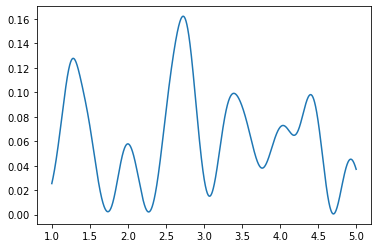

In [21]:
x_data = (np.sin(elevation_filtered*np.pi/180) * 4 * np.pi / WAVELENTH_S1).ravel()
y_data = snr1_ref.ravel()
w = np.linspace(1,5,10000)
power = signal.lombscargle(x_data,y_data,w,normalize=True)
plt.plot(w,power)

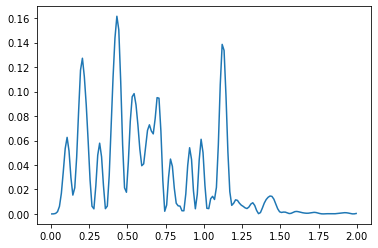

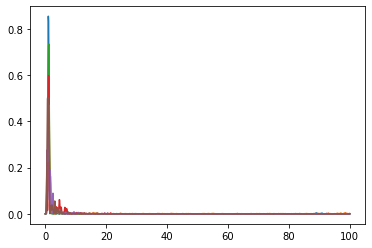

In [ ]:
min_height = 1
max_height = 3 # meter
time_interval = 5 # minutes

if not dataframe.empty:
    time_list, height_list, azimut_list = esth.split_result(dataframe,time_interval,min_height,max_height)


/Users/ziqing/opt/anaconda3/envs/gnss_ir/lib/python3.9/site-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


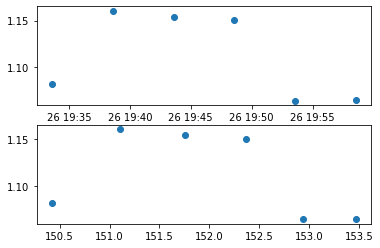

In [ ]:
plt.subplot(2,1,1)
plt.scatter(time_list,height_list)
plt.subplot(2,1,2)
plt.scatter(azimut_list,height_list)

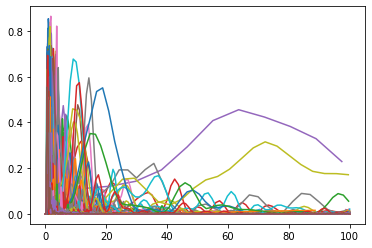

In [ ]:
time_dict = {}
height_dict = {}
azimut_dict = {}
for satellite_code in data_dict:
    dataframe = data_dict[satellite_code]
    if not dataframe.empty:
        time_dict[satellite_code], height_dict[satellite_code], azimut_dict[satellite_code]\
             = esth.split_result(dataframe,time_interval,min_height,max_height)

/Users/ziqing/opt/anaconda3/envs/gnss_ir/lib/python3.9/site-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


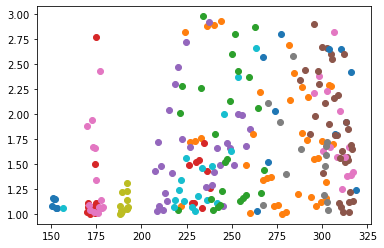

In [ ]:
for satellite_code in azimut_dict:
    plt.scatter(azimut_dict[satellite_code], height_dict[satellite_code])